<a href="https://colab.research.google.com/github/robitussin/CCDEPLRL_EXERCISES/blob/main/exercise4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4


## Instructions


1. Collect **100-200 images** of the fruit
2. Split the collected images for train, test and validation. Please make sure that there are no duplicate images. Images that are used in train should not appear in test, validation and vice versa.
3. Combine the collected images together with the images of apple, orange and banana. They  are already available in the link below: https://github.com/robitussin/tensorflow_lite_projects/tree/main/images/fruits
4. Create and train a Convolutional Neural Network (CNN).
5. Save the model as **"model.tflite"**
6. Create a folder named **exercise_4** in your **CCDEPLRL_EXERCISES_COM222_ML** repository.
7. Upload the **python notebook (.ipynb)** and the **model (.tflite)** in the exercise_3 folder

Deadline of submission is on **April 22, 2025**

## Model

In [ ]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2025-04-22 07:21:36--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 13.200.41.136, 13.200.41.135, 13.200.41.134, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip’

fruits.zip          100%[===================>] 101.04M  17.1MB/s    in 6.2s    

2025-04-22 07:21:44 (16.3 MB/s) - ‘fruits.zip’ saved [105946856/105946856]



In [ ]:
!unzip fruits.zip

Archive:  fruits.zip
   creating: fruits/
  inflating: __MACOSX/._fruits       
  inflating: fruits/.DS_Store        
  inflating: __MACOSX/fruits/._.DS_Store  
   creating: fruits/test/
   creating: fruits/train/
   creating: fruits/validation/
   creating: fruits/test/apple/
  inflating: fruits/test/.DS_Store   
  inflating: __MACOSX/fruits/test/._.DS_Store  
   creating: fruits/test/banana/
   creating: fruits/test/orange/
   creating: fruits/train/apple/
  inflating: fruits/train/.DS_Store  
  inflating: __MACOSX/fruits/train/._.DS_Store  
   creating: fruits/train/banana/
   creating: fruits/train/orange/
   creating: fruits/validation/apple/
  inflating: fruits/validation/.DS_Store  
  inflating: __MACOSX/fruits/validation/._.DS_Store  
   creating: fruits/validation/banana/
   creating: fruits/validation/orange/
  inflating: fruits/test/apple/Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflating: __MACOSX/fruits/test/apple/._Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflatin

Import the libraries

In [177]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


Hyperparameters: Set the image size and batch size

In [202]:
img_height, img_width = 64, 64
batch_size = 10

Split the images into train, validation and test

In [203]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 538 files belonging to 4 classes.
Found 83 files belonging to 4 classes.
Found 147 files belonging to 4 classes.


Display sample images from the dataset

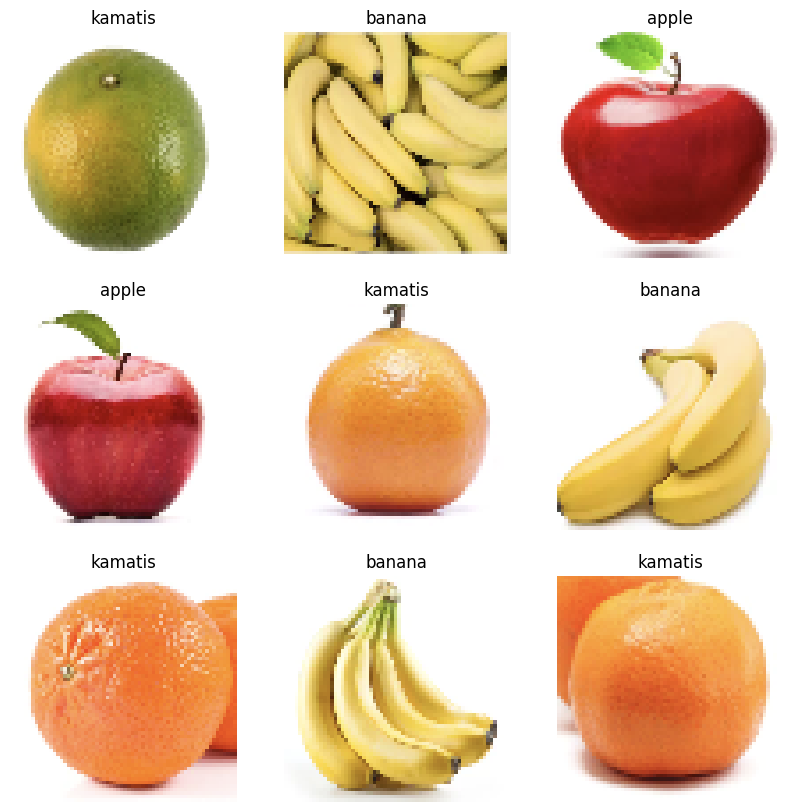

In [204]:
class_names = ["apple", "banana", "orange", "kamatis"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [205]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(100).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.1)
])

def mixup(ds, alpha=0.2):
    def _mix(image, label):
        beta = tf.random.uniform([], 0, 1)
        beta = tf.cast(beta, tf.float32)
        image1, label1 = image
        image2, label2 = image
        return beta * image1 + (1 - beta) * image2, label1 if beta > 0.5 else label2
    return ds.map(_mix, num_parallel_calls=AUTOTUNE)

Create the Convolutional Neural Network Model (CNN)

In [206]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(16, 4, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, 4, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 4, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 4, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 4, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])


In [208]:
model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_41 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_27 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Define the optimizer and loss function

In [209]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Remove label_smoothing
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

Train the model

In [210]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)


Epoch 1/50
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6880 - loss: 0.8280
Epoch 1: val_accuracy improved from -inf to 0.39759, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6937 - loss: 0.8149 - val_accuracy: 0.3976 - val_loss: 1.3486 - learning_rate: 0.0010
Epoch 2/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8902 - loss: 0.3722
Epoch 2: val_accuracy improved from 0.39759 to 0.43373, saving model to best_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8905 - loss: 0.3705 - val_accuracy: 0.4337 - val_loss: 1.5702 - learning_rate: 0.0010
Epoch 3/50
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9003 - loss: 0.3243
Epoch 3: val_accuracy did not improve from 0.43373
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8993 - loss: 0.3254 - val_accuracy: 0.4096 - val_loss: 2.3479 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9114 - loss: 0.3167
Epoch 4: Redu

Test the model

In [211]:
model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9897 - loss: 0.0697


[0.1278301626443863, 0.9727891087532043]

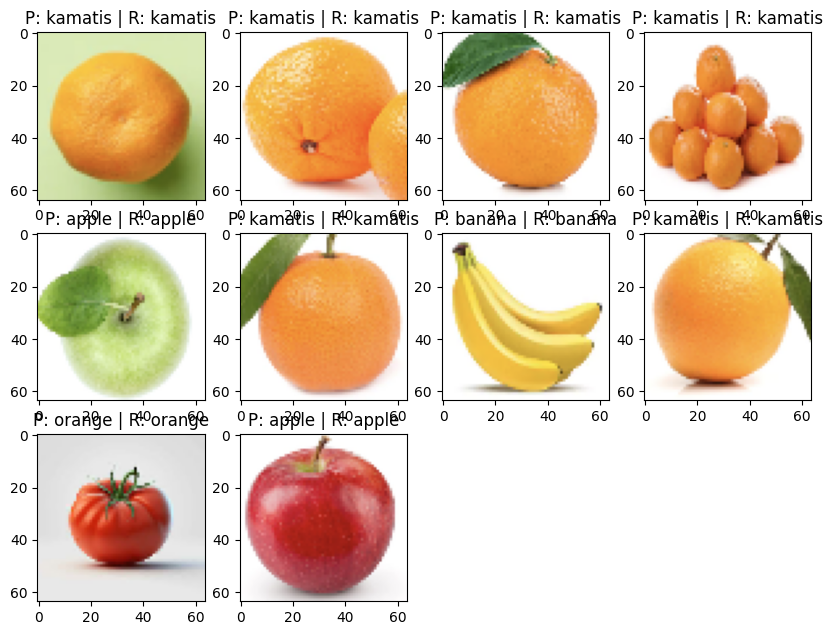

In [212]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)

  # Change loop range to the number of images in the batch
  for i in range(len(images)):  # or range(images.shape[0])
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("P: " + class_names[index] + " | R: " + class_names[labels[i]])

Save the model

In [ ]:
model.save["fruitID.tflite"]

Saved artifact at '/tmp/tmps0vsrqqm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138049941998096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049941998288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049941997328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049780290320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049780289744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049780291280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049780291664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049780292624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049780293008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138049780293968: TensorSpec(shape=(), dtype=tf.resource, name=None)
